# Import the required libraries

In [1]:
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spaCy
import spacy
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#vis 
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

#import nltk

from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

C:\ProgramData\Anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# Import data

In [2]:
imdb_data = pd.read_csv("imdb_labelled.txt",  names=['review','label'], delimiter=".\t")
imdb_data

C:\Users\Quynh Pham\AppData\Local\Temp\ipykernel_10288\3627405509.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imdb_data = pd.read_csv("imdb_labelled.txt",  names=['review','label'], delimiter=".\t")


,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [3]:
review = imdb_data.review.tolist()
review[:3]

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man. ',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out. ',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent. ']

# Prepare data

In [4]:
# create a spacy object, disable parser and ner for the script to run a bit faster
nlp = spacy.load('en_core_web_sm', disable=['parser','ner']) 

#get the list of stop words
stopwords = stopwords.words('english')
stopwords.append('movie')
stopwords.append('film')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
# function to preprocess the review
def preprocess(texts, allowed_postags=['NOUN','VERB','ADJ','ADV']):    
    lemmatizer = WordNetLemmatizer()
    filter_sentence = []
    temp = []
    words = gensim.utils.simple_preprocess(str(texts), deacc=True) # gensim - lowercase, tokenize, de-accents
    words = [w for w in words if not w in stopwords] # stopwords removal
    temp = ' '.join(x for x in words) # combine the tokens into a sentence again
    doc = nlp(temp)
    for word in doc: # go through each words in that clean sentence
        if word.pos_ in allowed_postags: # remove words that are not verb or noun
            filter_sentence.append(word.lemma_) # lemmatization
    return filter_sentence

In [6]:
# build the dictionary

corpus = [preprocess(line) for line in review]
corpus[:3]

[['slow', 'move', 'aimless', 'distressed', 'drift', 'young', 'man'],
 ['sure', 'lose', 'flat', 'character', 'audience', 'nearly', 'half', 'walk'],
 ['attempt',
  'artiness',
  'black',
  'white',
  'clever',
  'camera',
  'angle',
  'disappoint',
  'become',
  'even',
  'ridiculous',
  'act',
  'poor',
  'plot',
  'line',
  'almost',
  'existent']]

In [7]:
# build the dicationary with gensim

dictionary = corpora.Dictionary(corpus)
len(dictionary)

2122

In [8]:
# convert corpus into bag-of-words format
bow = [dictionary.doc2bow(line) for line in corpus]
print(bow[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [9]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w in modeldict.keys()]
    fig,ax=plt.subplots()
    ax.imshow(model.get_topics())  # plot the numpy matrix
    ax.set_xticks(modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

In [10]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corpus] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
    # visualize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=10)]))
#    if print_dist:
        # display the topic probabilities for each document
#        for line,bag in zip(txt,bow):
#            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
#            print('{} {}'.format(line, doc_topics))
    return model

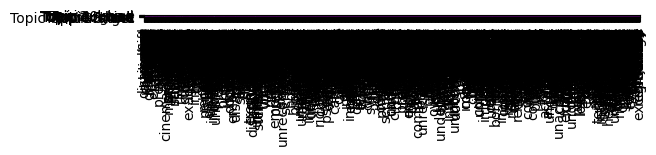

Perplexity: -7.84
Topic 0: ['bad', 'make', 'well', 'movie', 'show', 'real', 'work', 'film', 'still', 'like']
Topic 1: ['even', 'come', 'totally', 'understand', 'amazing', 'top', 'whole', 'feel', 'comedy', 'hole']
Topic 2: ['know', 'line', 'say', 'many', 'take', 'interesting', 'job', 'minute', 'man', 'actually']
Topic 3: ['think', 'look', 'good', 'story', 'end', 'wonderful', 'write', 'performance', 'excellent', 'pretty']
Topic 4: ['black', 'camera', 'set', 'attempt', 'become', 'white', 'cool', 'use', 'history', 'cinema']
Topic 5: ['see', 'act', 'script', 'play', 'go', 'ever', 'thing', 'recommend', 'never', 'funny']
Topic 6: ['good', 'actor', 'cast', 'much', 'suck', 'little', 'music', 'screen', 'simply', 'quite']
Topic 7: ['character', 'great', 'scene', 'love', 'watch', 'also', 'plot', 'give', 'way', 'year']
Topic 8: ['get', 'part', 'character', 'game', 'start', 'fail', 'self', 'special', 'lose', 'portrayal']
Topic 9: ['time', 'really', 'waste', 'find', 'dialogue', 'story', 'big', 'piece

In [11]:
test_eta('auto', dictionary, ntopics=10)

In [12]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [13]:
predifined_topic = {
    'plot':0, 'show':0, 'write':0, 'end':0,  'story':0, 'scene':0, 'script':0, 'writer':0, 'thought':0, 'spoiler':0, 'tell':0, 'begin':0, 'drama':0, 'fact':0, 'line':0, 'dialogue':0,'word':0,
    'character':1,'actor':1, 'kid':1, 'act':1, 'performance':1, 'cast':1, 'character':1, 'create':1, 'child':1, 'experience':1, 'action':1, 'star':1, 'play':1,'acting':1,'actress':1,
    'part':2, 'screen':2, 'art':2, 'effect':2, 'direct':2,'song':2,'music':2, 'camera':2, 'shoot':2, 'cinematography':2,
    'horror':3, 'comedy':3, 'love':3, 'cartoon':3,'theme':3,'life':3,'suspense':3,
    'work':4,'year':4, 'fan':4, 'time':4,'production':4,'cost':4
}
eta = create_eta(predifined_topic, dictionary, 5)

In [14]:
eta

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2]])

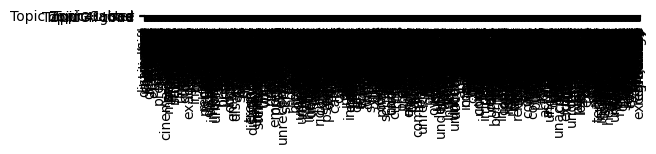

Perplexity: 2.08
Topic 0: ['bad', 'well', 'act', 'really', 'make', 'good', 'movie', 'love', 'see', 'scene']
Topic 1: ['see', 'even', 'watch', 'thing', 'get', 'recommend', 'go', 'many', 'totally', 'awful']
Topic 2: ['character', 'give', 'much', 'funny', 'suck', 'come', 'little', 'art', 'enjoy', 'take']
Topic 3: ['good', 'great', 'look', 'end', 'make', 'wonderful', 'pretty', 'part', 'avoid', 'horror']
Topic 4: ['time', 'story', 'think', 'script', 'plot', 'play', 'also', 'actor', 'waste', 'year']


In [15]:
test_eta(eta, dictionary, ntopics=5)

In [16]:
predifined_topic = {
    'play':1, 'plot':1, 'drama':1, 'fact':1, 'reason':1, 'scene':1, 'dialog':1, 'story':1, 'word':1, 'write':1, 'story':1, 'script':1, 'word':1, 
    'action':0, 'believable':0, 'look':0, 'act':0, 'cast':0, 'acting':0,
    'camera':2, 'movie':2, 'film':2, 'scene':2, 'beautiful':2, 'cinematography':2, 'direct':2,  'shoot':2, 'interesting':2, 'music':2,
    'theme':3, 'life':3, 'horror':3, 'human':3,
    'solid':4, 'production':4, 'cost':4, 'show':4
}
eta = create_eta(predifined_topic, dictionary, 5)

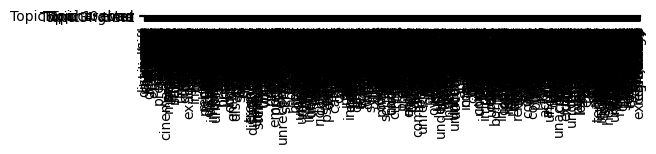

Perplexity: 2.10
Topic 0: ['bad', 'good', 'see', 'make', 'well', 'really', 'act', 'love', 'movie', 'work']
Topic 1: ['even', 'watch', 'get', 'thing', 'see', 'recommend', 'go', 'write', 'many', 'totally']
Topic 2: ['character', 'give', 'say', 'much', 'funny', 'suck', 'come', 'watch', 'art', 'enjoy']
Topic 3: ['great', 'good', 'film', 'end', 'wonderful', 'make', 'see', 'part', 'life', 'pretty']
Topic 4: ['time', 'story', 'think', 'actor', 'script', 'plot', 'play', 'also', 'waste', 'cast']


In [17]:
test_eta(eta, dictionary, ntopics=5)